In [547]:
import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats, signal
from tensorflow.python.ops import math_ops

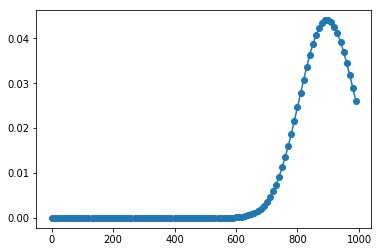

In [791]:
loss_a = np.zeros((100,2))
loss_a[:,0] = np.arange(0, 1000,10)
#loss_a_prob = [0.2, 0 , 0, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.2]
loss_a[:,1] = stats.binom(1000,0.09).pmf(np.arange(100))
plt.plot(loss_a[:,0], loss_a[:,1], "o-")

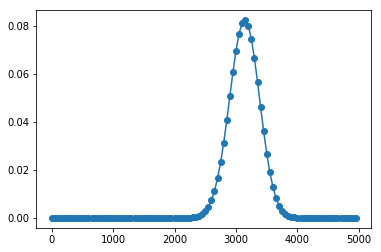

In [909]:
loss_b = np.zeros((100,2))
loss_b[:,0] = np.arange(0, 5000, 50)

loss_b[0,1] = 0.5
loss_b[-1,1] = 0.5
loss_b[:,1] = stats.binom(100, 0.627).pmf(np.arange(100))

plt.plot(loss_b[:,0], loss_b[:,1], 'o-')

In [910]:
values = np.add.outer(loss_a[:,0], loss_b[:,0]).flatten()
probs = np.multiply.outer(loss_a[:,1], loss_b[:,1]).flatten()
df = pd.DataFrame({'values': values, 'probs': probs})
conv = df.groupby('values').sum()
result = conv.reset_index().values

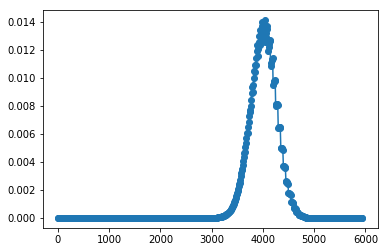

In [911]:
plt.plot(result[:,0], result[:,1], 'o-')

In [912]:
v_sorted = np.argsort(values)
values_s = values[v_sorted]
probs_s = probs[v_sorted]

In [913]:
bins = np.digitize(values_s, np.linspace(0,max(values_s),100))

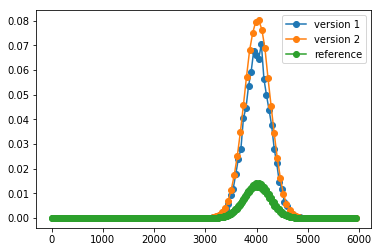

In [914]:
# version 1
values_out1 = np.mean(values_s.reshape((100,100)), axis=1)
probs_out1 = np.sum(probs_s.reshape((100,100)), axis=1)
# version 2
values_out2 = np.array([np.mean(values_s[bins==b]) for b in set(bins)])
probs_out2 = np.array([np.sum(probs_s[bins==b]) for b in set(bins)])
plt.plot(values_out1, probs_out1, 'o-', label="version 1")
plt.plot(values_out2, probs_out2, 'o-', label="version 2")
plt.plot(result[:,0], result[:,1], 'o-', label="reference")
plt.legend()

## Tensorflow version

In [915]:
def combine_losses(loss_a, loss_b):
    client_loss_v = tf.reshape(tf.expand_dims(loss_a[:,0],1) + tf.expand_dims(loss_b[:,0],0), [-1])
    sortation = tf.contrib.framework.argsort(client_loss_v)
    client_loss_p = tf.reshape(tf.einsum('i,j->ij', loss_a[:,1], loss_b[:,1]), [-1])
    cl_v_sorted = tf.gather(client_loss_v, sortation)
    v = tf.concat((tf.fill([100],cl_v_sorted[0]), cl_v_sorted, tf.fill([100],cl_v_sorted[-1])), axis=0)
    cl_p_sorted = tf.gather(client_loss_p, sortation)
    paddings = tf.constant([[100, 100]])
    p = tf.pad(cl_p_sorted, paddings, "CONSTANT")
    cl_v_sum = tf.reduce_mean(tf.reshape(v, (100,102)), axis=1)
    cl_p_sum = tf.reduce_sum(tf.reshape(p, (100,102)), axis=1)
    comb_loss = tf.stack([cl_v_sum, cl_p_sum], 1)
    return comb_loss

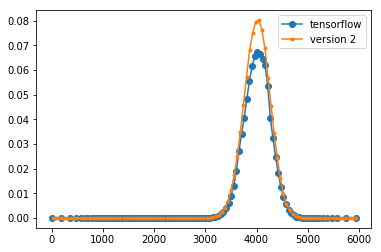

In [920]:
comb_loss = combine_losses(tf.Variable(loss_a), tf.Variable(loss_b))
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    comb_loss = sess.run(comb_loss)
plt.plot(comb_loss[:,0], comb_loss[:,1], 'o-', label="tensorflow")
plt.plot(values_out2, probs_out2, '.-', label="version 2")
plt.legend()

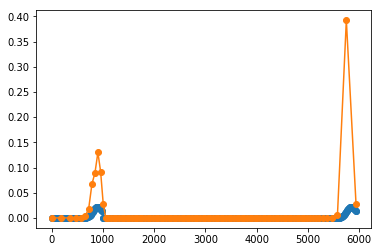

In [846]:
sess = tf.Session()
comb_loss = sess.run((cl_v_sum, cl_p_sum), feed_dict={locloss_a: loss_a, locloss_b: loss_b})
plt.plot(result[:,0], result[:,1], 'o-')
plt.plot(v, p, 'o-')
#plt.plot(values_out2, probs_out2, 'o-')


In [850]:
sum(p), sum(result[:,1])

(0.8528234940305115, 0.8528235062221684)

In [854]:
x = tf.placeholder(np.float32, shape=(None,))
uniform = tf.distributions.Uniform(0.,2.)
sess.run(tf.expand_dims(locloss_a[:,0],0), feed_dict={locloss_a: loss_a})

array([[  0.,  10.,  20.,  30.,  40.,  50.,  60.,  70.,  80.,  90., 100.,
        110., 120., 130., 140., 150., 160., 170., 180., 190., 200., 210.,
        220., 230., 240., 250., 260., 270., 280., 290., 300., 310., 320.,
        330., 340., 350., 360., 370., 380., 390., 400., 410., 420., 430.,
        440., 450., 460., 470., 480., 490., 500., 510., 520., 530., 540.,
        550., 560., 570., 580., 590., 600., 610., 620., 630., 640., 650.,
        660., 670., 680., 690., 700., 710., 720., 730., 740., 750., 760.,
        770., 780., 790., 800., 810., 820., 830., 840., 850., 860., 870.,
        880., 890., 900., 910., 920., 930., 940., 950., 960., 970., 980.,
        990.]], dtype=float32)

In [581]:
conv_values = tf.nn.conv1d(

    # dimensions of this input (for NWC format) is [ batch, in_width, in_channels]
    #tf.reshape(uniform.prob(x), (1,-1,1)), 
    tf.reshape(locloss_b[:,1], (1,-1,1)),
    
    # dimensions of the filter are [ filter_width, in_channels, out_channels ]
    # note the minus sign of x
    #tf.reshape(uniform.prob(-x), (-1,1,1)), 
    tf.reshape(locloss_a[:,1], (-1,1,1)), 
    
    stride = 1,
    padding = 'SAME',
    data_format = 'NWC'
    )

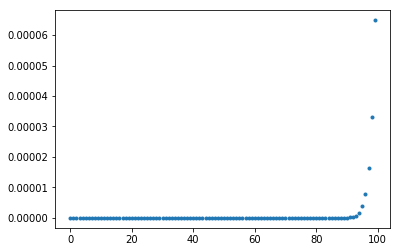

In [587]:
plt.plot(sess.run(conv_values, feed_dict={locloss_a: a_loss, locloss_b: b_loss}).reshape(-1), '.')